In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [4]:
IMAGE_FOLDER = 'digit-recognizer/'
TRAIN_CSV = 'train.csv' 
TEST_CSV = 'test.csv'

CLASSES = 10
EPOCHS = 100
# BATCH_SIZE = 20
LR = 0.0005

VERBOSE = True

In [5]:
dataset = pd.read_csv(os.path.join(IMAGE_FOLDER, TRAIN_CSV))
test_dataset = pd.read_csv(os.path.join(IMAGE_FOLDER, TEST_CSV))
set_lenght = int(len(dataset) * 0.9)

train_dataset = np.array(dataset[:set_lenght])
val_dataset = np.array(dataset[set_lenght:])

X_test = np.array(test_dataset)

In [6]:
X_train = train_dataset[:, 1:]
y_train = train_dataset[:, 0]

X_val = val_dataset[:, 1:]
y_val = val_dataset[:, 0]


X_train.shape, y_train.shape 

((37800, 784), (37800,))

In [7]:
# array of one-hot encoded vectors from vector of labels
def one_hot(vector):
    one_hot = np.zeros((vector.shape[0], CLASSES), dtype = int)
    one_hot[np.arange(vector.size), vector] = 1
    return one_hot


In [13]:
def show_images(images, label, nrows, ncolumns):
    images = images.T
    num_images = images.shape[1]
    
    _, axes = plt.subplots(nrows, ncolumns, figsize=(ncolumns*3, nrows*3))
    axes = axes.flatten()

    if nrows * ncolumns < num_images:
        print(f"Not all images are shown. Images provided: {num_images}. Please change number of columns of rows")

    for i in range(nrows * ncolumns):
        one_hot_enc = one_hot(label[i].reshape(1,1))

        if num_images < i +1:
            axes[i].imshow(np.zeros((28, 28)))
            axes[i].set_title(f"Empty")
        else:   
            axes[i].imshow(images[:, i].reshape(28, 28))
            axes[i].set_title(f"Label:{label[i].item()}\n One-Hot: {one_hot_enc.squeeze()}")

    plt.tight_layout()
        

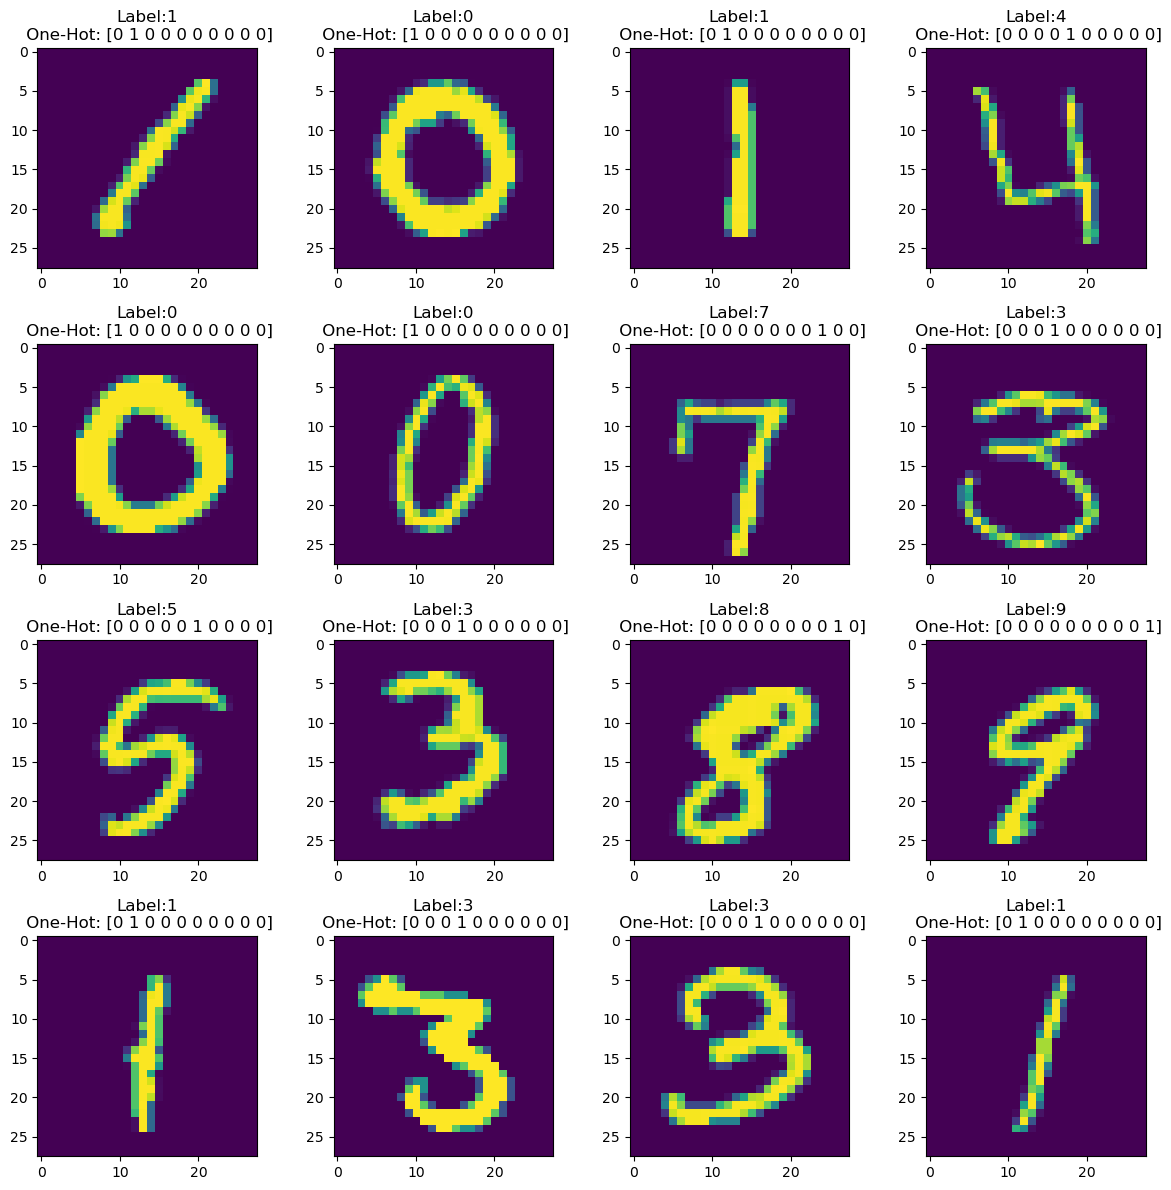

In [14]:
show_images(X_train[:16], y_train[:16], 4, 4)

In [15]:
def softmax(x):
    A = np.exp(x - np.max(x, axis=0))
    B = np.sum(A, axis=0)
    return A / B

def cross_entropy_loss(predictions, targets):
    return -np.sum(targets * np.log(predictions + 1e-9)) / predictions.shape[1]

def cross_entropy_loss_derivative(predictions, targets):
    return predictions - targets

def predictions(prediction):
    return np.argmax(prediction, 0)

def accuracy(prediction, target_label):
    return np.sum(prediction == target_label) / target_label.size

In [16]:
def init_params(input_size=784, hidden_layer_size=392, output_size=10):
    w_0 = np.random.uniform(-0.5, 0.5, (hidden_layer_size, input_size))
    b_0 = np.zeros((hidden_layer_size, 1))

    w_1 = np.random.uniform(-0.5, 0.5, (output_size, hidden_layer_size))
    b_1 = np.zeros((output_size, 1))

    return w_0, b_0, w_1, b_1


In [17]:
def train(X_train, y_train, w_0, b_0, w_1, b_1):
    image, label = X_train.T, y_train
    
    # initialization of input layer and target
    target = one_hot(label).T
    input_layer = image

    # forward propagation
    #1
    hidden_layer = w_0 @ input_layer + b_0

    #2
    logits = w_1 @ hidden_layer + b_1
    output = softmax(logits)

    # Cost function
    loss = cross_entropy_loss(output, target)
    pred = predictions(output)
    acc = accuracy(pred, label)
        
    # backpropagation 
    #1
    delta_output_hidden = cross_entropy_loss_derivative(output, target)
    w_1_grad = delta_output_hidden @ hidden_layer.T
    b_1_grad = np.sum(delta_output_hidden, axis=1, keepdims=True)
    
    #2
    delta_hidden_input = w_1.T @ delta_output_hidden
    w_0_grad = delta_hidden_input @ input_layer.T
    b_0_grad = np.sum(delta_hidden_input, axis=1, keepdims=True)


    # Gradient clipping to avoid exploding gradients
    w_1_grad = np.clip(w_1_grad, -1, 1)
    b_1_grad = np.clip(b_1_grad, -1, 1)
    w_0_grad = np.clip(w_0_grad, -1, 1)
    b_0_grad = np.clip(b_0_grad, -1, 1)

    w_1 += -LR * w_1_grad
    b_1 += -LR * b_1_grad
    w_0 += -LR * w_0_grad
    b_0 += -LR * b_0_grad


    return w_0, b_0, w_1, b_1, loss, acc
    

In [18]:
def validation(X_val, y_val, w_0, b_0, w_1, b_1):
    image, label = X_val.T, y_val
    
    # initialization of input layer and target
    target = one_hot(label).T
    input_layer = image

    # forward propagation
    #1
    hidden_layer = w_0 @ input_layer + b_0

    #2
    logits = w_1 @ hidden_layer + b_1
    output = softmax(logits)

    # Cost function
    loss = cross_entropy_loss(output, target)
    pred = predictions(output)
    acc = accuracy(pred, label)

    return loss, acc
    

In [19]:
def predict_digit_label(X_test, w_0, b_0, w_1, b_1):
    image = X_test.T
    input_layer = image

    # forward propagation
    #1
    hidden_layer = w_0 @ input_layer + b_0

    #2
    logits = w_1 @ hidden_layer + b_1
    output = softmax(logits)

    # Cost function
    pred = predictions(output)

    return X_test, pred

In [20]:
batches = [1]

epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_loss = []
epoch_val_accuracy = []


w_0, b_0, w_1, b_1 = init_params(input_size=784, hidden_layer_size=392, output_size=CLASSES)

for epoch in range(EPOCHS):
    batch_loss = []
    batch_accuracy = []
    batch_val_loss = []
    batch_val_accuracy = []

    for batch in batches:
        w_0, b_0, w_1, b_1, loss, acc  = train(X_train, y_train, w_0, b_0, w_1, b_1)
        val_loss, val_acc  = validation(X_val, y_val, w_0, b_0, w_1, b_1)

        batch_loss.append(loss)
        batch_accuracy.append(acc)
        batch_val_loss.append(val_loss)
        batch_val_accuracy.append(val_acc)
        

    # metrics
    epoch_train_loss.append(np.mean(batch_loss))
    epoch_train_accuracy.append(np.mean(batch_accuracy)*100)
    epoch_val_loss.append(np.mean(batch_val_loss))
    epoch_val_accuracy.append(np.mean(batch_val_accuracy)*100)

    if VERBOSE:
        print(f"Epoch {epoch+1}")
        print(f"-- Train Loss {epoch_train_loss[epoch]:.4f} - Train Accuracy {epoch_train_accuracy[epoch]:.4f}")   
        print(f"-- Validation Loss {epoch_val_loss[epoch]:.4f} - Validation Accuracy {epoch_val_accuracy[epoch]:.4f}\n")                

Epoch 1
-- Train Loss 18.8071 - Train Accuracy 9.2063
-- Validation Loss 18.6360 - Validation Accuracy 10.0238

Epoch 2
-- Train Loss 18.7322 - Train Accuracy 9.5741
-- Validation Loss 18.5948 - Validation Accuracy 10.1905

Epoch 3
-- Train Loss 18.6758 - Train Accuracy 9.8386
-- Validation Loss 18.4813 - Validation Accuracy 10.7857

Epoch 4
-- Train Loss 18.5375 - Train Accuracy 10.4894
-- Validation Loss 18.2709 - Validation Accuracy 11.7857

Epoch 5
-- Train Loss 18.3579 - Train Accuracy 11.3519
-- Validation Loss 17.9791 - Validation Accuracy 13.1905

Epoch 6
-- Train Loss 18.0966 - Train Accuracy 12.6085
-- Validation Loss 17.6053 - Validation Accuracy 14.9048

Epoch 7
-- Train Loss 17.7811 - Train Accuracy 14.1323
-- Validation Loss 17.1677 - Validation Accuracy 17.0238

Epoch 8
-- Train Loss 17.4000 - Train Accuracy 15.9577
-- Validation Loss 16.7177 - Validation Accuracy 19.2381

Epoch 9
-- Train Loss 16.9500 - Train Accuracy 18.1164
-- Validation Loss 16.3048 - Validation Accu

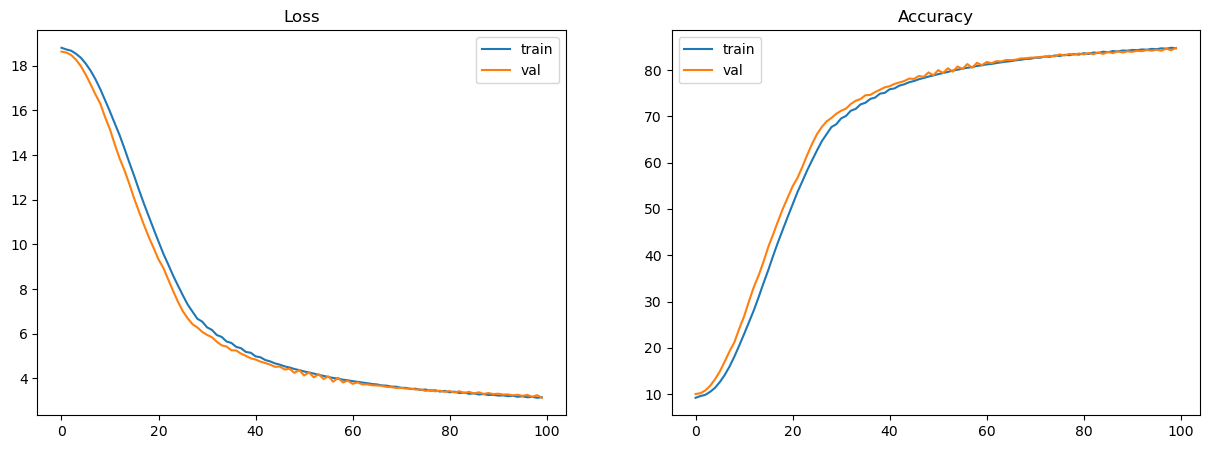

In [21]:
def show_graphs(train_loss, train_accuracy, val_loss, val_accuracy):
    _, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(train_loss)
    axes[0].plot(val_loss)
    axes[0].set_title(f"Loss")
    axes[0].legend(["train", "val"])                    
    axes[1].plot(train_accuracy)
    axes[1].plot(val_accuracy)
    axes[1].set_title(f"Accuracy")
    axes[1].legend(["train", "val"])


show_graphs(epoch_train_loss, epoch_train_accuracy, epoch_val_loss, epoch_val_accuracy)

In [22]:
images, pred = predict_digit_label(X_test[140:172], w_0, b_0, w_1, b_1)
print(images.shape)

(32, 784)


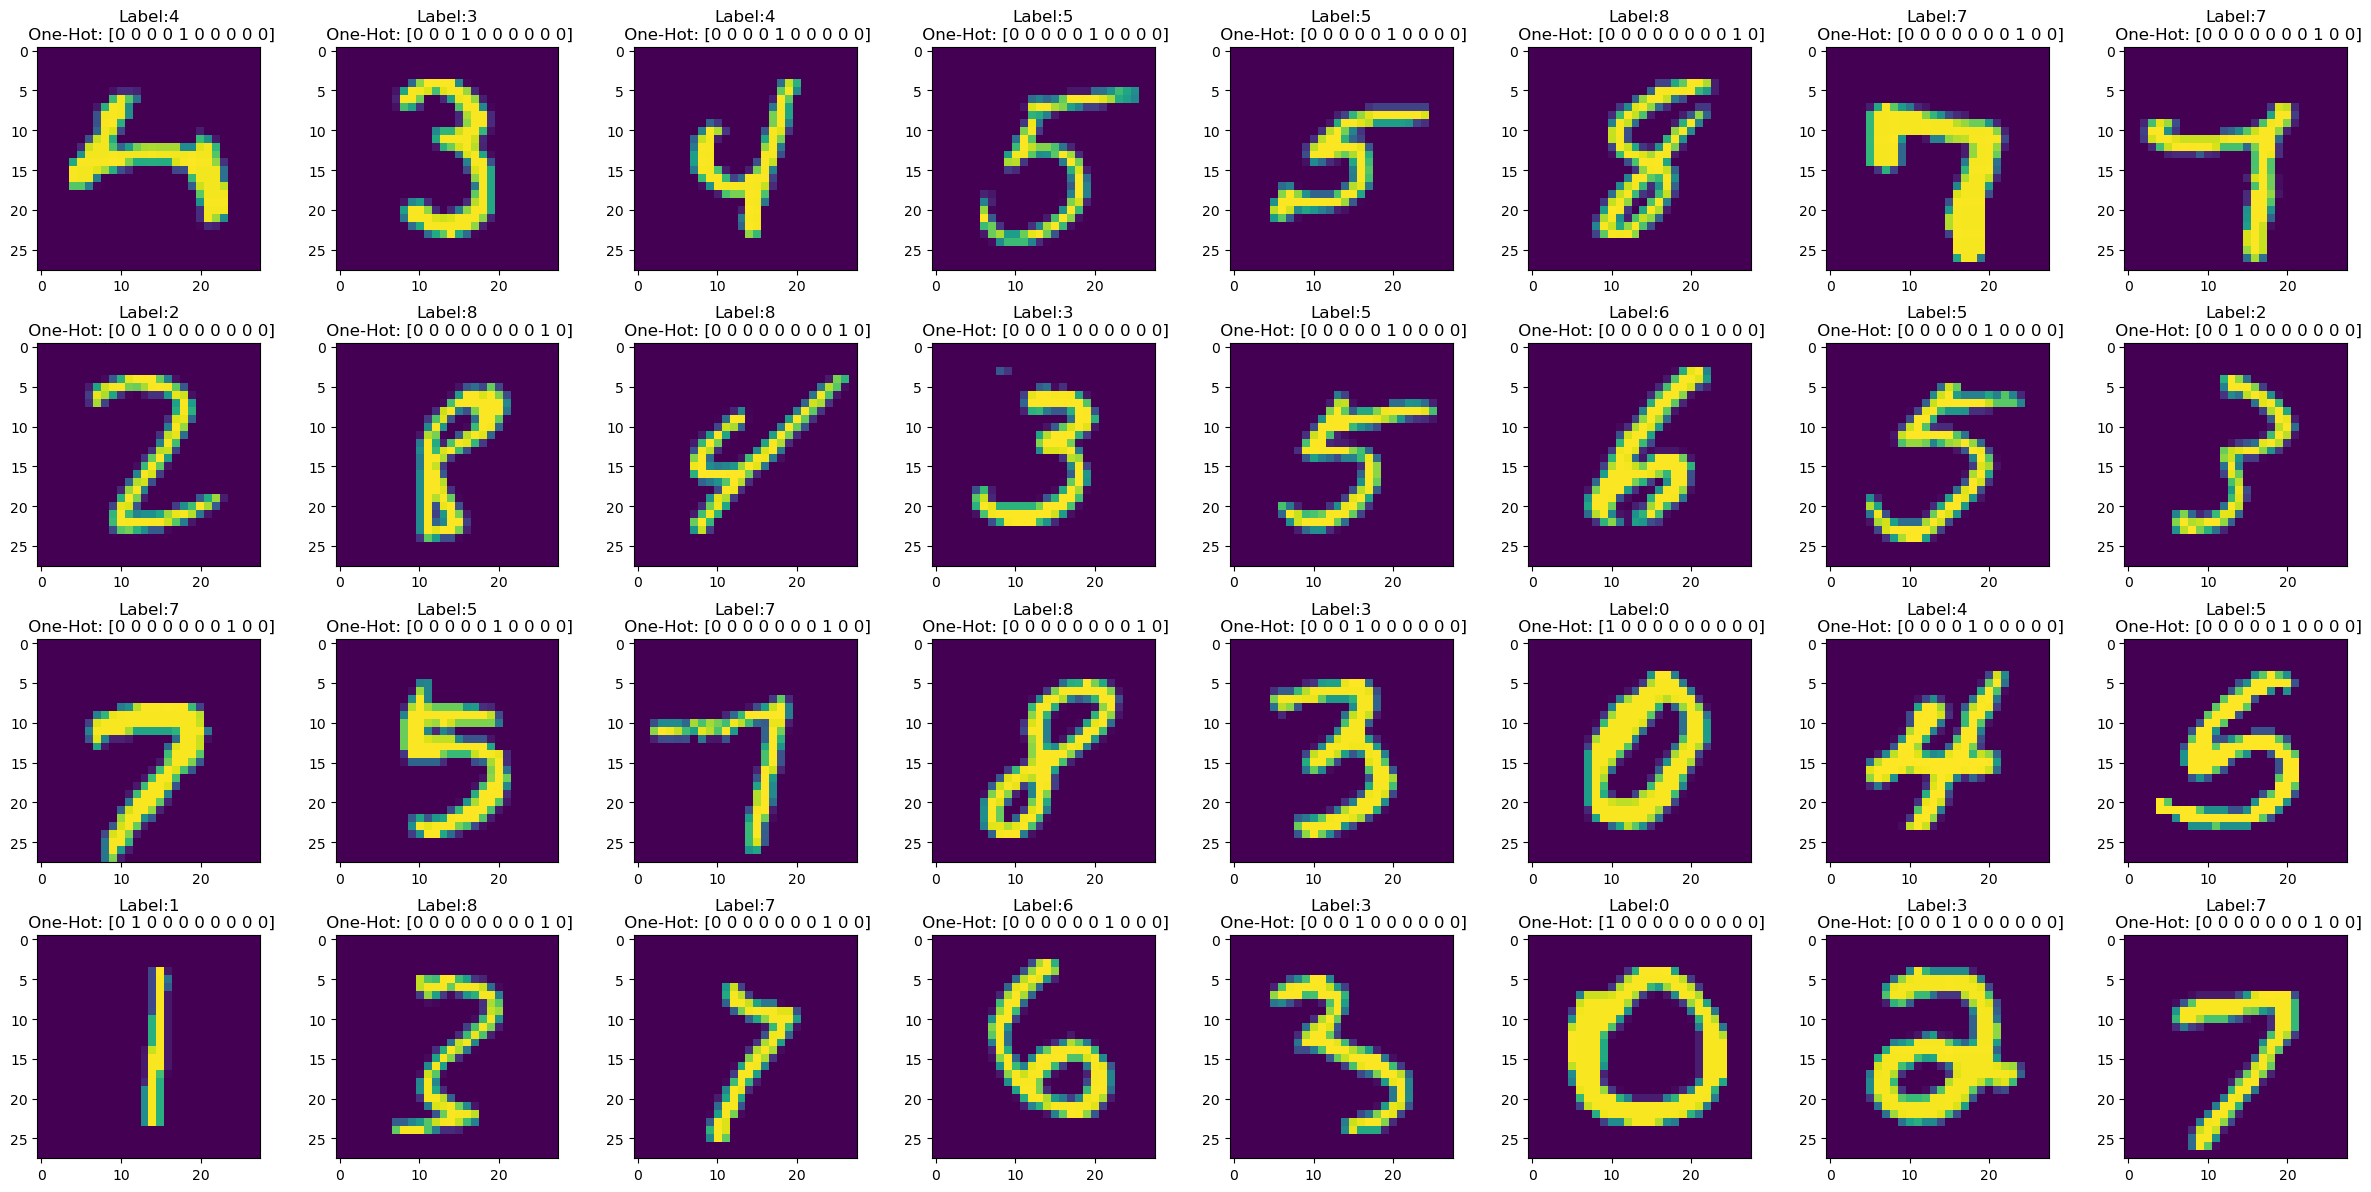

In [24]:
show_images(images, pred, 4, 8)